In [1]:
# need to check bias term
# need to check regularization term
# recurrent connection is all zero 


import sys
sys.path.append('../')

from low_rank_rnns.modules_connectivity_fullRank import *
from low_rank_rnns import TF, stats, plotting as plot, helpers, rankone, ranktwo, clustering

from matplotlib import pyplot as plt
# %matplotlib notebook
import random
import numpy as np

import torch

In [2]:
size = 400
noise_std = 1e-2
alpha = .1
lr = 1e-3

input_size = 3
output_size = 1


In [3]:
x_train, y_train, mask_train, cohAll_train, x_val, y_val, mask_val, cohAll_val = TF.generate_checker_data(10000)


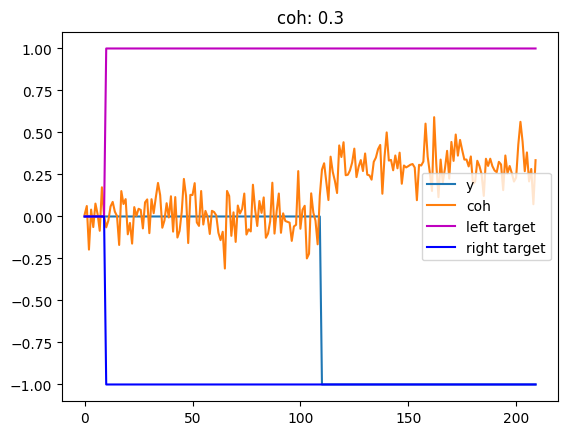

In [4]:
n = 8

plt.plot(y_val[n,:,:], label = 'y')
plt.plot(x_val[n,:,0], label = 'coh')
plt.plot(x_val[n,:,1], 'm', label = 'left target')
plt.plot(x_val[n,:,2], 'b', label = 'right target')
plt.title('coh: ' + str(cohAll_val[n]))
plt.legend()




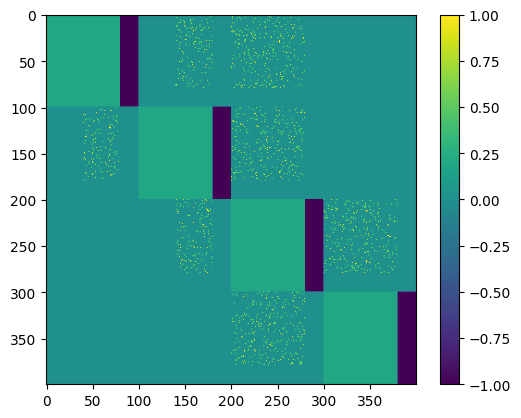

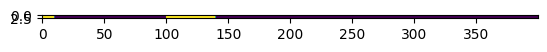

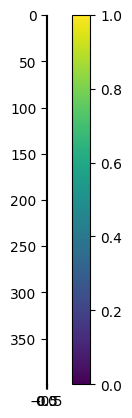

tensor(-14.)


In [5]:
# local connections are sparce
# def create_local_conn(Inum, ratio, n_neurons):

#     mask_rec = torch.zeros(n_neurons, n_neurons)
    
#     mask_rec[:,n_neurons-Inum:] = -1
    
#     # Define the size of the matrix
#     rows, cols = n_neurons, n_neurons-Inum
    
#     # Create a zero matrix
#     matrix = torch.zeros(rows, cols)
    
#     # Calculate the number of entries to set to 1
#     num_entries = int(ratio * rows * cols)
    
#     # Randomly select indices
#     indices = torch.randperm(rows * cols)[:num_entries]
    
#     # Set the selected entries to 1
#     matrix.view(-1)[indices] = 1
    
#     mask_rec[:,:n_neurons-Inum] = matrix    

#     return mask_rec

# local connections are continuous 
def create_local_conn(Inum, ratio, n_neurons):

    mask_rec = torch.zeros(n_neurons, n_neurons)
    
    mask_rec[:,n_neurons-Inum:] = -1
    
    mask_rec[:,:n_neurons-Inum] = ratio    

    return mask_rec



def create_area_conn(Inum, ratio, n_neurons): 
    mask_rec = torch.zeros(n_neurons, n_neurons)
    
    mask_rec[:,n_neurons-Inum:] = 0
    mask_rec[n_neurons-Inum:,:] = 0
    
    # Define the size of the matrix
    rows, cols = n_neurons-Inum, n_neurons-Inum
    
    # Create a zero matrix
    matrix = torch.zeros(rows, cols)
    
    # Calculate the number of entries to set to 1
    num_entries = int(ratio * rows * cols)
    
    # Randomly select indices
    indices = torch.randperm(rows * cols)[:num_entries]
    
    # Set the selected entries to 1
    matrix.view(-1)[indices] = 1
    
    mask_rec[:n_neurons-Inum,:n_neurons-Inum] = matrix

    return mask_rec

# # areal connections are continuous 
# def create_area_conn(Inum, ratio, n_neurons): 
#     mask_rec = torch.zeros(n_neurons, n_neurons)
    
#     mask_rec[:,n_neurons-Inum:] = 0
#     mask_rec[n_neurons-Inum:,:] = 0
    
    
#     mask_rec[:n_neurons-Inum,:n_neurons-Inum] = ratio

#     return mask_rec



n_neurons = 400
n_inputs = 3
n_outputs = 1


mask_rec = torch.zeros(n_neurons, n_neurons)
mask_in = torch.zeros(n_inputs, n_neurons)
mask_out = torch.ones(n_neurons, n_outputs)


mask_rec[:100,0:100] = create_local_conn(20,0.2,100)
mask_rec[100:200,100:200] = create_local_conn(20,0.2,100)
mask_rec[200:300,200:300] = create_local_conn(20,0.2,100)
mask_rec[300:400,300:400] = create_local_conn(20,0.2,100)


connStrength = 0.0456


mask_rec[:100,100:200] = create_area_conn(20,connStrength,100)
mask_rec[:100,100:140] = 0
# mask_rec[40:80,100:140] = 0
# mask_rec[:40,140:180] = 0



mask_rec[100:200,0:100] = create_area_conn(20,connStrength,100)
# mask_rec[140:180,0:40] = 0
# mask_rec[100:140,40:80] = 0
mask_rec[100:200,0:40] = 0

mask_rec[100:200,200:300] = create_area_conn(20,connStrength,100)


mask_rec[200:300,100:200] = create_area_conn(20,connStrength,100)
mask_rec[200:300,100:140] = 0



mask_rec[200:300,300:400] = create_area_conn(20,connStrength,100)
mask_rec[300:400,200:300] = create_area_conn(20,connStrength,100)

mask_rec[0:100,200:300] = create_area_conn(20,connStrength,100)
# mask_rec[40:100,200:300] = 0





mask_in[0,:40] = 1
mask_in[1:,:10] = 1


mask_in[1:,100:140] = 1
mask_in[0,100:110] = 1

# mask_in[:,:80] = 1


mask_out[:300,:] = 0
mask_out[380:,:] = 0










wi_mask = mask_in
wo_mask = mask_out
wrec_mask = mask_rec.t()

plt.imshow(mask_rec, cmap = 'viridis')
plt.colorbar()
plt.show()

plt.imshow(wi_mask)
plt.show()
plt.imshow(wo_mask)
plt.colorbar()
plt.show()


print(torch.sum(wrec_mask))

tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         

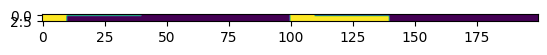

In [6]:
plt.imshow(wi_mask[:,:200])
wi_mask[:,:100]

In [29]:

net = FullRankRNN(3, size, 1, noise_std, alpha, train_wi=True, train_wo = True, train_h0=True, 
                  wrec_mask = wrec_mask, wi_mask = wi_mask, wo_mask = wo_mask, 
                 b_init = None, add_biases = False)

# after trained, recurrent connectivity are all zero
# after trained, bias term will make test accuracy very low
net.non_linearity = torch.relu
net.out_non_linearity = torch.relu

# net.out_non_linearity = torch.eye

train(net, x_train, y_train, mask_train, n_epochs=50, lr=lr, batch_size=100, 
      mask_gradients = False, keep_best=True, cuda=True, early_stop=0.25, clip_gradient = 1)

x_val, y_val, mask_val = map_device([x_val, y_val, mask_val], net)


loss, acc, out, decisions, target_decisions, traj = TF.test_checker(net, x_val, y_val, mask_val)
print(f'loss={loss:.3f}, acc={acc:.3f}')

Training...
initial loss: 1.000
epoch 0:  loss=1.000  (took 9.60 s)
epoch 1:  loss=1.000  (took 9.61 s)
epoch 2:  loss=0.996  (took 9.68 s) *
epoch 3:  loss=0.877  (took 9.65 s) *
epoch 4:  loss=0.768  (took 9.64 s) *
epoch 5:  loss=0.737  (took 9.53 s) *
epoch 6:  loss=0.716  (took 9.52 s) *
epoch 7:  loss=0.680  (took 9.61 s) *
epoch 8:  loss=0.522  (took 9.51 s) *
epoch 9:  loss=0.386  (took 9.53 s) *
epoch 10:  loss=0.338  (took 9.63 s) *
epoch 11:  loss=0.313  (took 9.47 s) *
epoch 12:  loss=0.292  (took 9.51 s) *
epoch 13:  loss=0.276  (took 9.49 s) *
epoch 14:  loss=0.264  (took 9.51 s) *
epoch 15:  loss=0.250  (took 9.59 s) *
epoch 16:  loss=0.241  (took 9.53 s) *
loss=0.242, acc=1.000


In [30]:
attributes = net.__dict__

In [31]:
attributes.keys()

dict_keys(['training', '_parameters', '_buffers', '_non_persistent_buffers_set', '_backward_pre_hooks', '_backward_hooks', '_is_full_backward_hook', '_forward_hooks', '_forward_hooks_with_kwargs', '_forward_hooks_always_called', '_forward_pre_hooks', '_forward_pre_hooks_with_kwargs', '_state_dict_hooks', '_state_dict_pre_hooks', '_load_state_dict_pre_hooks', '_load_state_dict_post_hooks', '_modules', 'input_size', 'hidden_size', 'output_size', 'noise_std', 'alpha', 'rho', 'train_wi', 'train_wo', 'train_wrec', 'train_h0', 'train_si', 'train_so', 'non_linearity', 'output_non_linearity', 'wi_full', 'wo_full', 'out_non_linearity', 'w_rec_eff', 'w_in_eff', 'w_out_eff'])

In [32]:
attributes['non_linearity']

<function torch._VariableFunctionsClass.relu>

In [33]:
# # or load a RNN


# import sys
# sys.path.append('../')

# from low_rank_rnns.modules_connectivity_fullRank import *
# from low_rank_rnns import TF, stats, plotting as plot, helpers, rankone, ranktwo, clustering

# from matplotlib import pyplot as plt
# # %matplotlib notebook
# import random
# import numpy as np

# import torch
# size = 400
# noise_std = 1e-2
# alpha = .1
# lr = 1e-3

# input_size = 3
# output_size = 1

# # load a full-rank RNN
# net = FullRankRNN(3, size, 1, noise_std, alpha)
# net.load_state_dict(torch.load(f'../models/4areas2.pt', map_location='cpu'))


# # with torch.no_grad():
# #     net1.wi.copy_(net.w_in_eff)
# #     net1.wo.copy_(net.w_out_eff)
# #     net1.wrec.copy_(net.w_rec_eff)


# x_train, y_train, mask_train, cohAll_train, x_val, y_val, mask_val, cohAll_val = TF.generate_checker_data(5000)

# loss, acc, out, decisions, target_decisions, traj = TF.test_checker(net, x_val, y_val, mask_val)
# print(f'loss={loss:.3f}, acc={acc:.3f}')

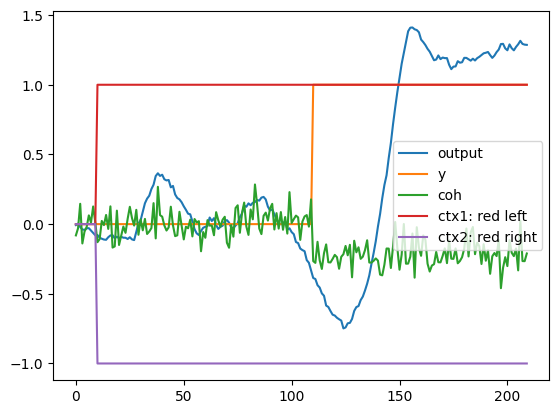

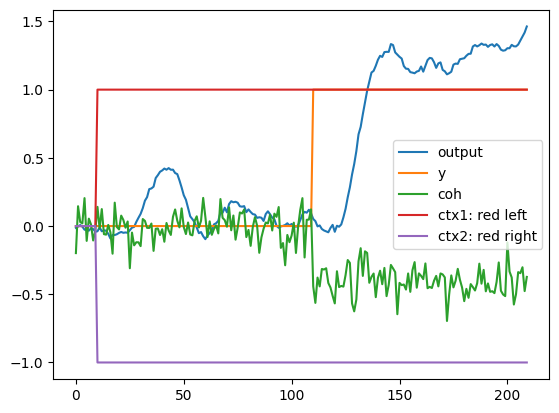

In [34]:
out = out.cpu()
y_val = y_val.cpu()
x_val = x_val.cpu()


for n in range(1, 3):
    plt.figure()
    aa = out.detach().numpy()
    plt.plot(aa[n,:,:], label = 'output')
    plt.plot(y_val[n,:,:], label = 'y')

    plt.plot(x_val[n,:,0], label = 'coh')
    plt.plot(x_val[n,:,1], label = 'ctx1: red left')
    plt.plot(x_val[n,:,2], label = 'ctx2: red right')

    plt.legend()
    plt.show()

# plot psth

In [35]:
traj = traj.cpu()
decisions = decisions.cpu()

traj1 = traj.detach().numpy()

traj1 = np.maximum(traj1,0)

decisions1 = decisions.detach().numpy()

tfRL = traj1[np.logical_and(decisions1 == -1, cohAll_val > 0),:,:]
tfRR = traj1[np.logical_and(decisions1 == 1, cohAll_val > 0),:,:]
tfGL = traj1[np.logical_and(decisions1 == -1, cohAll_val < 0),:,:]
tfGR = traj1[np.logical_and(decisions1 == 1, cohAll_val < 0),:,:]

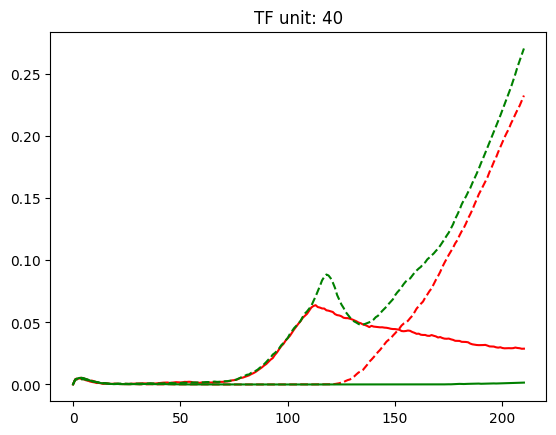

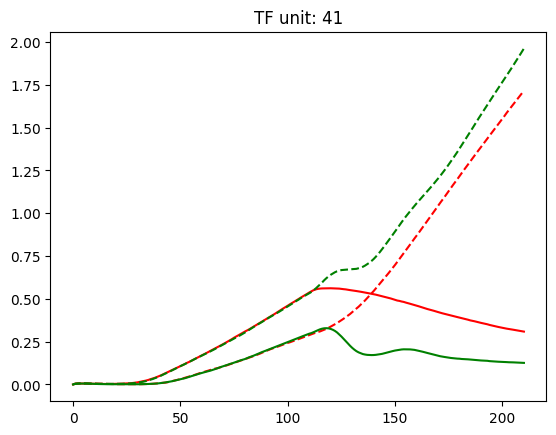

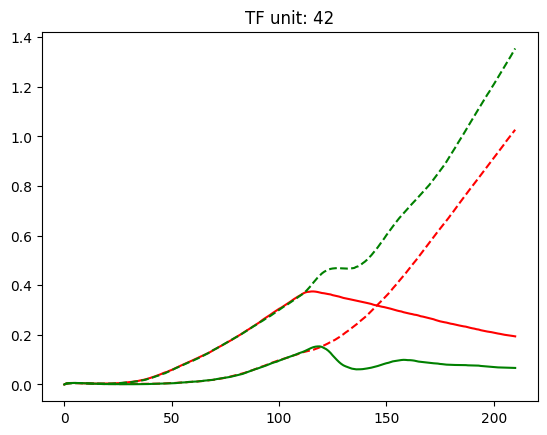

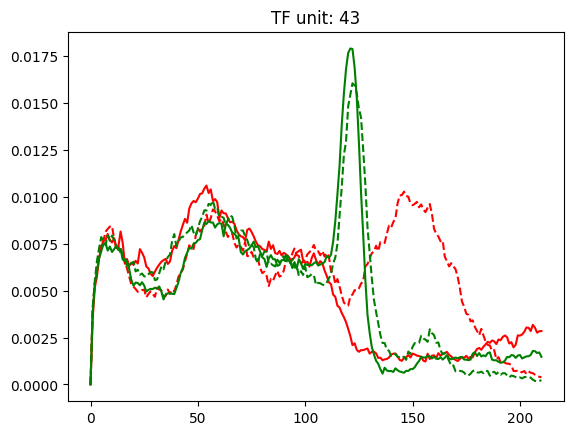

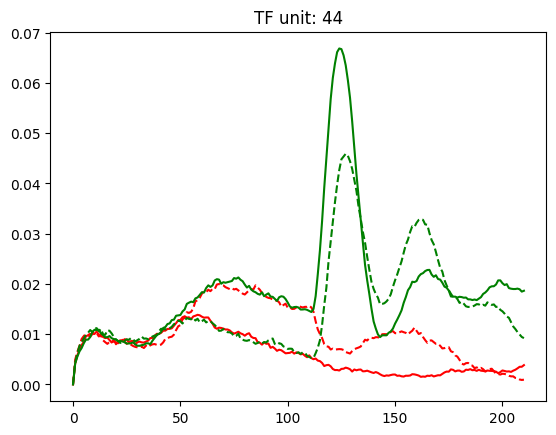

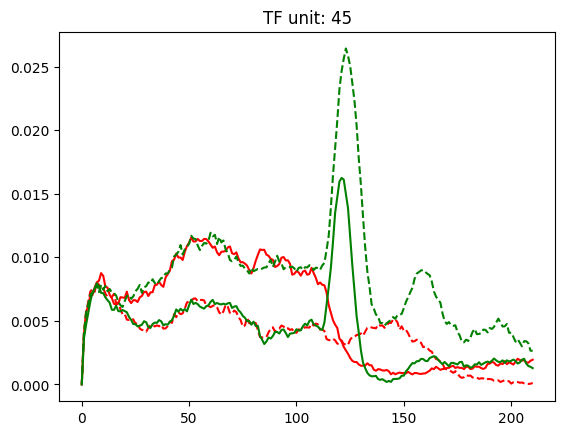

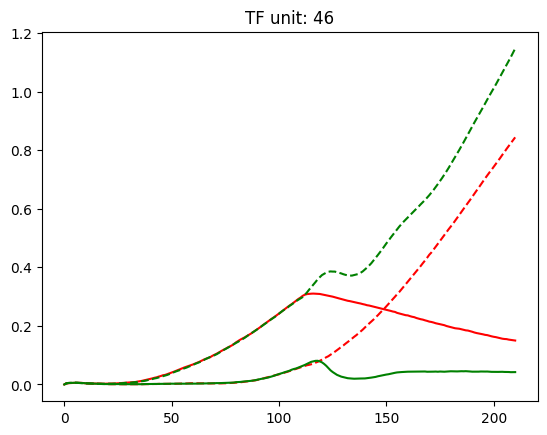

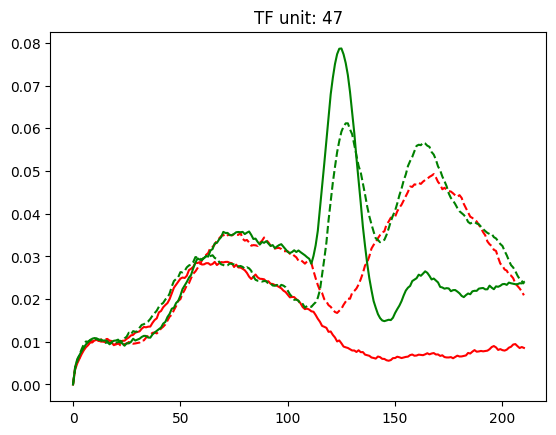

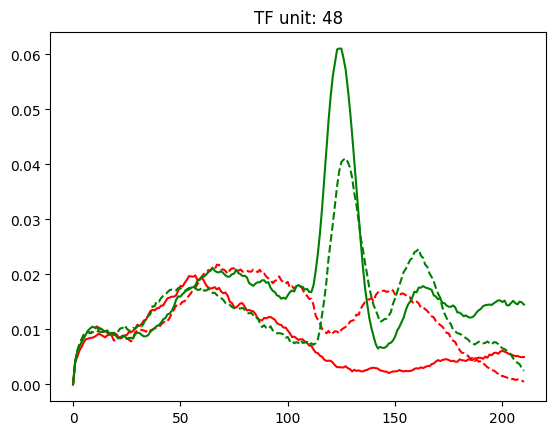

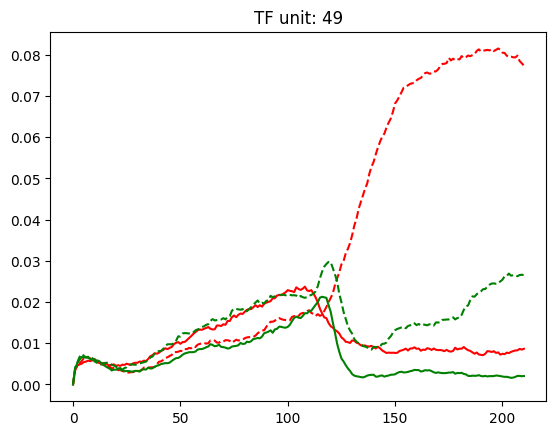

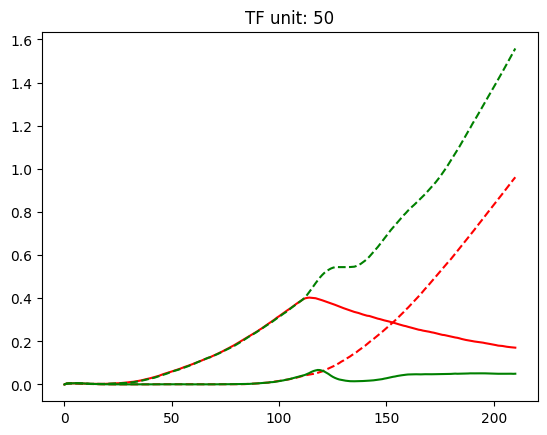

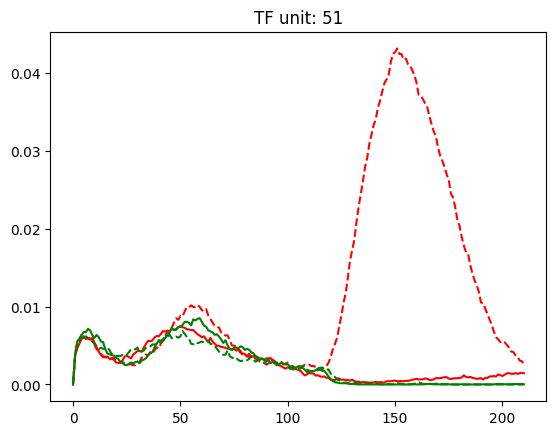

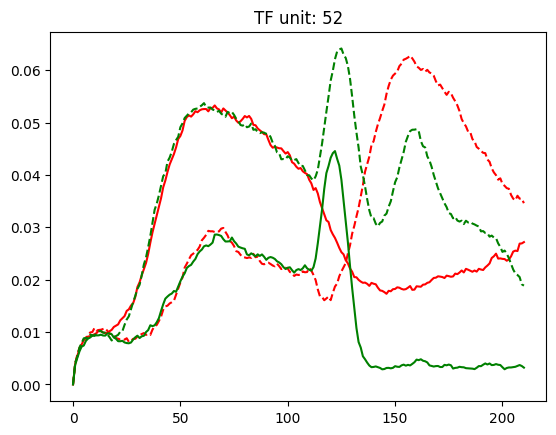

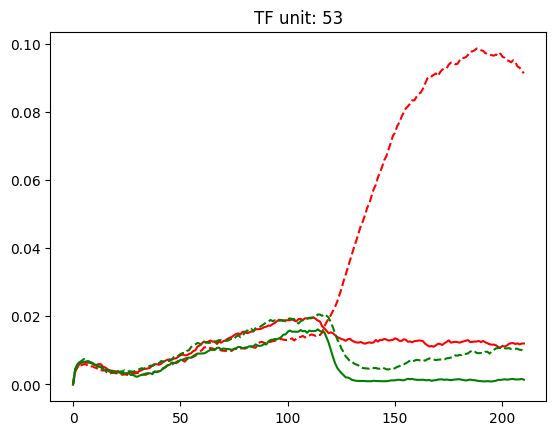

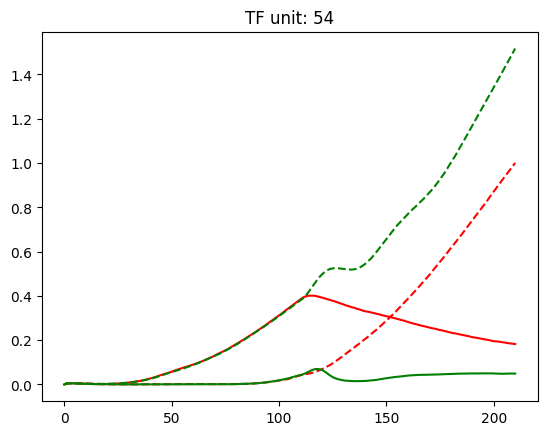

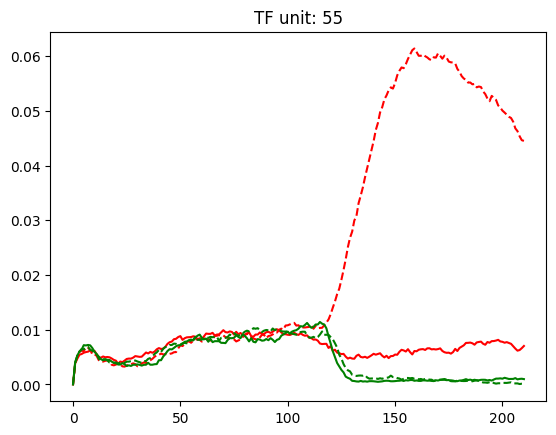

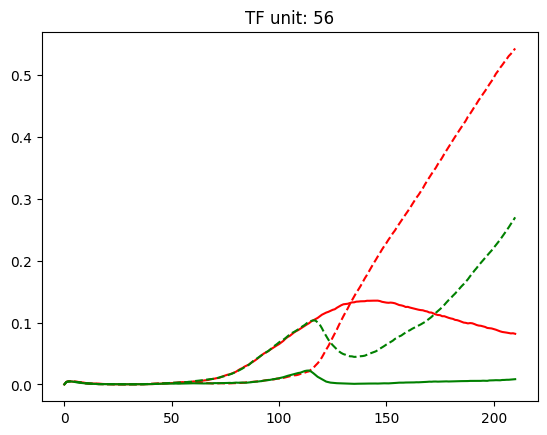

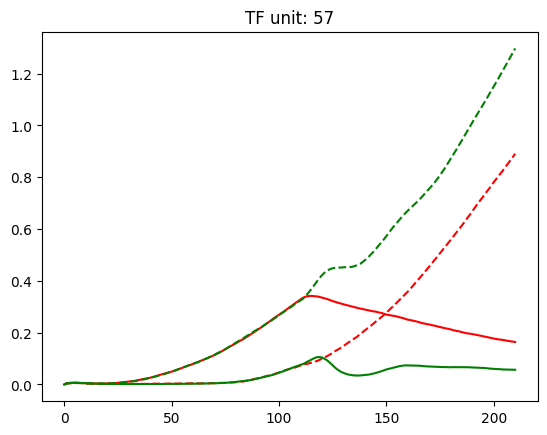

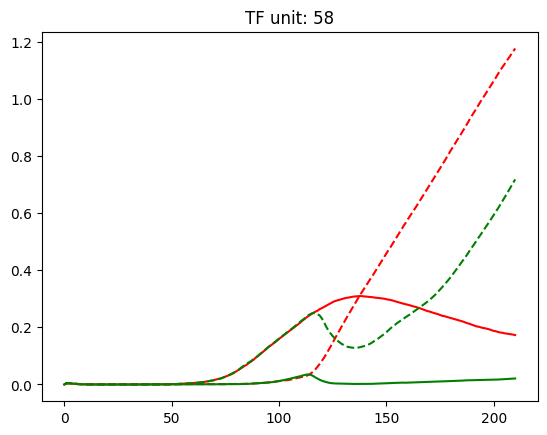

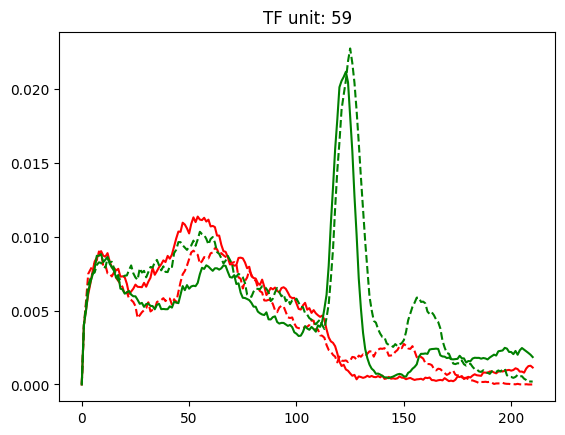

In [39]:
for n in range(40,60):
    plt.figure()
    plt.plot(np.mean(tfRL,axis = 0)[:,n], 'r-')
    plt.plot(np.mean(tfRR,axis = 0)[:,n], 'r--')
    plt.plot(np.mean(tfGL,axis = 0)[:,n], 'g-')
    plt.plot(np.mean(tfGR,axis = 0)[:,n], 'g--')
    plt.title("TF unit: " + str(n))
    

# plot the connectivity matrix


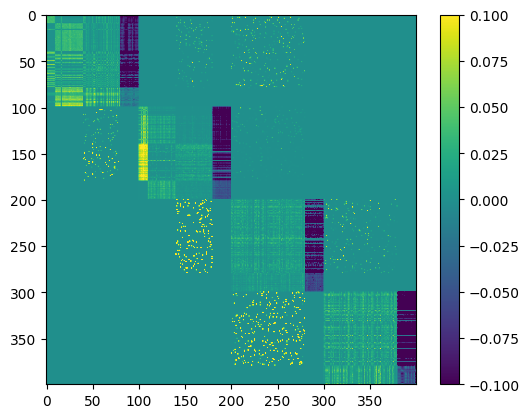

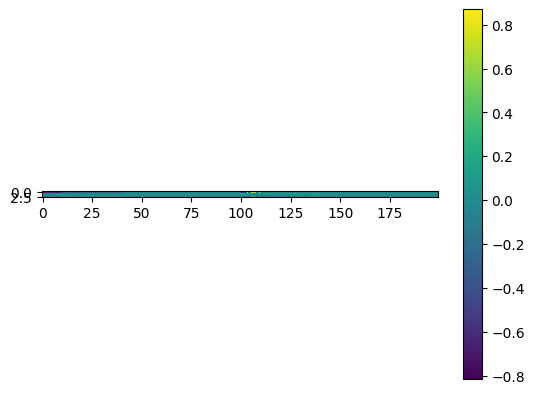

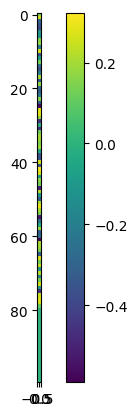

In [40]:
wrec = net.w_rec_eff.cpu()
wi = net.w_in_eff.cpu()
wo = net.w_out_eff.cpu()

a = wrec.detach().numpy()
plt.imshow(np.transpose(a))
plt.colorbar()
plt.set_cmap('viridis')
plt.clim(-0.1, 0.1)
plt.show()

b = wi.detach().numpy()
plt.imshow(b[:,:200])
plt.colorbar()
plt.set_cmap('viridis')
plt.show()

c = wo.detach().numpy()
plt.imshow(c[300:])
plt.colorbar()
plt.set_cmap('viridis')
plt.show()


In [47]:
# save the model
# torch.save(net.state_dict(), f'../models/4areas4.pt')

In [41]:
trajLow = np.zeros((4, tfRL.shape[1], tfRL.shape[2]))
trajLow[0,:,:] = np.mean(tfRL,axis = 0)
trajLow[1,:,:] =np.mean(tfRR,axis = 0)
trajLow[2,:,:] =np.mean(tfGL,axis = 0)
trajLow[3,:,:] =np.mean(tfGR,axis = 0)

(844, 100)


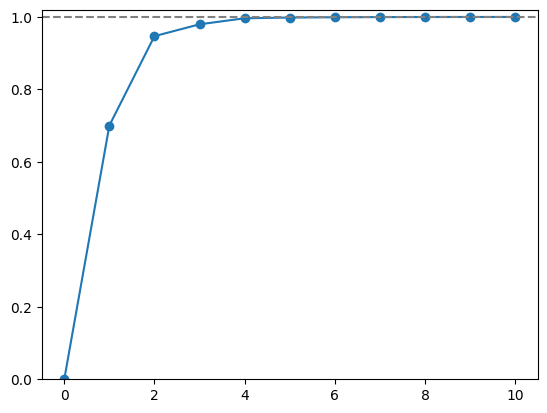

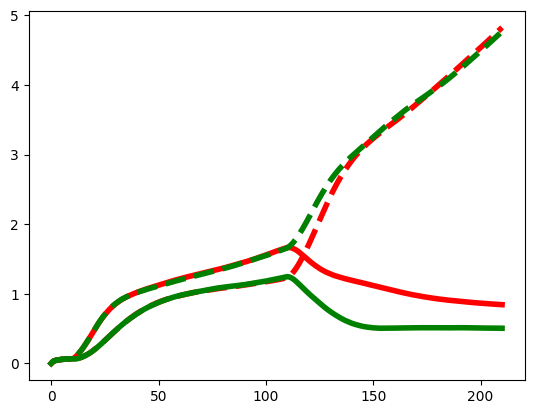

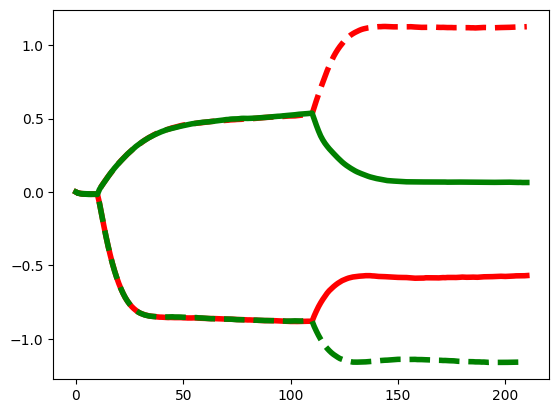

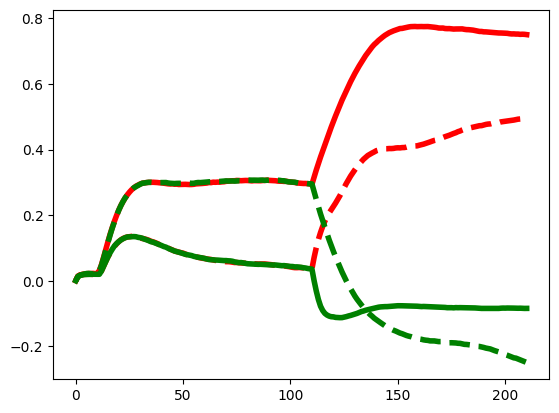

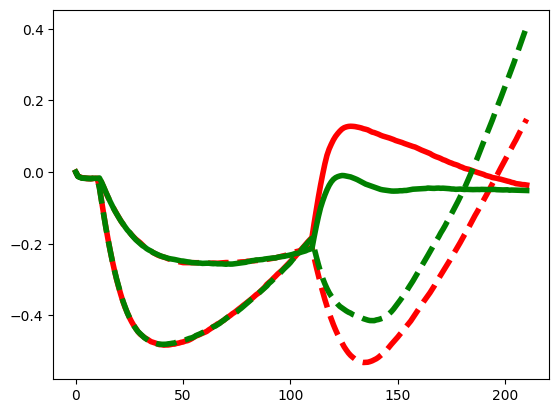

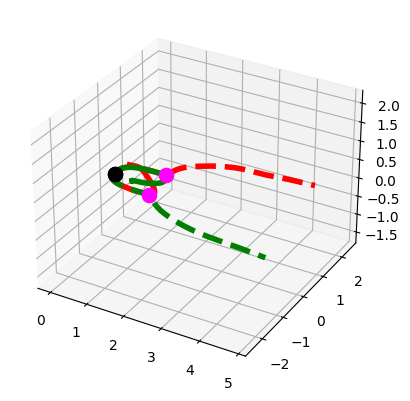

In [46]:
# low rank RNN PCA 

def areaPCA(trajLow):
    TOn = 10
    COn = 100
    
    pca = plot.pca_cumvar(trajLow, n_components=10)
    plt.ylim(0, 1.02)
    plt.axhline(1, ls='--', c='gray')
    plt.show()
    
    labels = ['RL', 'RR', 'GL', 'GR']
    colors = ['red', 'red', 'green', 'green']
    lineStyle = ['-', '--', '-', '--']
    
    ax1 = pca.components_[0]
    ax2 = pca.components_[1]
    ax3 = pca.components_[2]
    ax4 = pca.components_[3]
    
    k1 = trajLow @ ax1
    k2 = trajLow @ ax2
    k3 = trajLow @ ax3
    k4 = trajLow @ ax4
    
    plt.figure()
    for i in range(4):
    #      plt.plot(kap1[i], kap2[i], c=colors[i], lw=4, ls = lineStyle[i])
        plt.plot(k1[i], c=colors[i], lw=4, ls=lineStyle[i])
    plt.show()
    
    plt.figure()
    for i in range(4):
    #      plt.plot(kap1[i], kap2[i], c=colors[i], lw=4, ls = lineStyle[i])
        plt.plot(k2[i], c=colors[i], lw=4, ls=lineStyle[i])
    plt.show()
    
    plt.figure()
    for i in range(4):
        plt.plot(k3[i], c=colors[i], lw=4, ls = lineStyle[i], label=labels[i])
    plt.show()
    
    plt.figure()
    for i in range(4):
        plt.plot(k4[i], c=colors[i], lw=4, ls = lineStyle[i], label=labels[i])
    plt.show()
    
    # 3D pca plot
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    for i in range(4):
        plt.plot(k1[i], k2[i], k3[i], c=colors[i], lw=4, ls = lineStyle[i])
        ax.scatter(k1[i, TOn], k2[i, TOn], k3[i, TOn], c='black',
                marker='.', s=400)
        ax.scatter(k1[i, COn], k2[i, COn], k3[i, COn], c= 'magenta',
                marker='.', s=400)
    ax.axis('equal')

# area 1:
areaPCA(trajLow[:,:,100:200])
# area 2:
# areaPCA(trajLow[:,:,100:200])
# area 3:
# areaPCA(trajLow[:,:,200:])

In [66]:

# import sys
# import os


# other_directory_path = os.path.abspath('~/Documents/lowrank_interface/dPCA/python/dPCA/') 

# # Add the directory to sys.path
# sys.path.append(other_directory_path)


import sys
sys.path.append("../dPCA/python/dPCA/")

from numpy import *
from numpy.random import rand, randn, randint
from dPCA import dPCA

In [67]:
area = np.arange(200,300)

dim = trajLow.shape
X = np.zeros((100,2,2,dim[1]))

X[:,0,0,:] = (trajLow[0,:,area])
X[:,0,1,:] = (trajLow[1,:,area])
X[:,1,0,:] = (trajLow[2,:,area])
X[:,1,1,:] = (trajLow[3,:,area])


In [68]:
X.shape

(100, 2, 2, 211)

In [69]:

# Assuming data is a 4D ndarray with shape (units, stimuli, decisions, time)
# Example dimensions: (units, stimuli, decisions, time)
units, stimuli, decisions, time = X.shape

# Step 1: Set the dPCA labels (keep dimensions intact)

# Step 2: Apply dPCA directly on the 4D data
dPCA_obj = dPCA.dPCA(labels='sdt')  # Apply dPCA with some regularization
transformed_data = dPCA_obj.fit_transform(X)  # Perform dPCA

# # Step 3: Plot low-dimensional trajectories
# # Plot first two principal components for a low-dimensional visualization
# plt.figure(figsize=(8, 6))
# plt.plot(transformed_data[:, 0], transformed_data[:, 1], 'o-')
# plt.title('Low-dimensional Trajectories')
# plt.xlabel('PC1')
# plt.ylabel('PC2')
# plt.show()

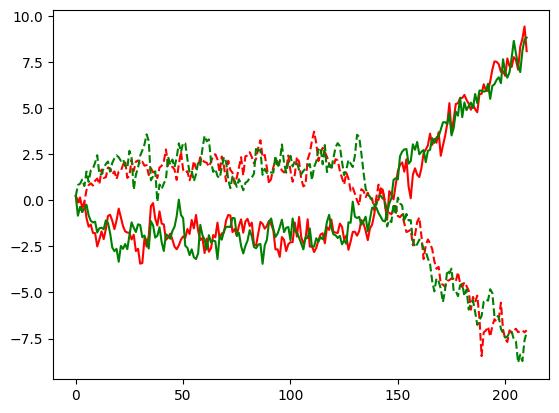

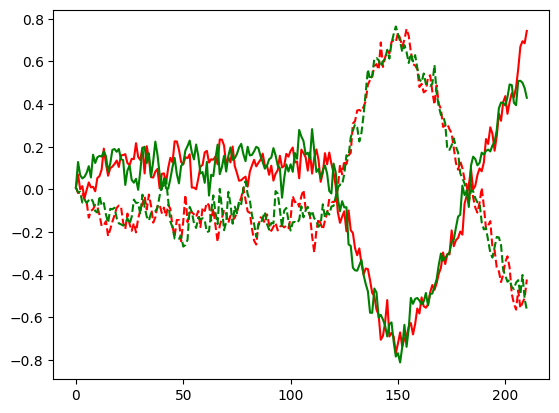

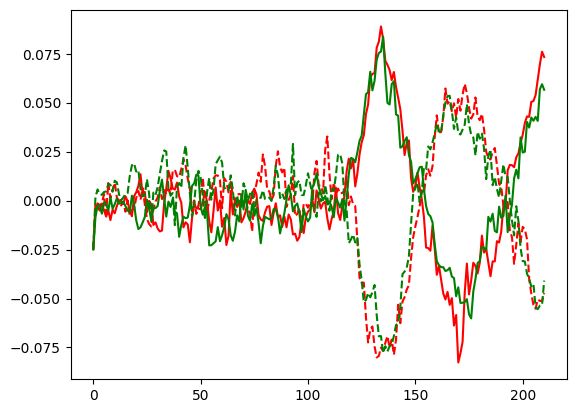

In [70]:
ss = transformed_data['dt']

for ii in range(3):
    plt.plot(ss[ii,0,0,:], 'r-')
    plt.plot(ss[ii,0,1,:], 'r--')
    plt.plot(ss[ii,1,0,:], 'g-')
    plt.plot(ss[ii,1,1,:], 'g--')
    plt.show()